In [1]:
!pip install -Uqq fastai duckduckgo_search ipywidgets
from fastai.vision.all import * 
from duckduckgo_search import ddg_images
from fastcore.all import * 
from fastdownload import download_url
import os 
from fastcore.all import * 
from fastai.vision.widgets import *

In [2]:
def is_cat(x): return x[0].isupper()

In [4]:
path = untar_data(URLs.PETS)/'images'
dls = ImageDataLoaders.from_name_func('.',
                                      get_image_files(path), 
                                      valid_pct=0.2, 
                                      seed=42,
                                      label_func=is_cat,
                                      item_tfms=Resize(192))

In [5]:
def search_images(term, max_images=30):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
urls = search_images('grizzly bear')
dest = 'images/grizzly.jpg'
download_url(urls[0], dest)

Path('images/grizzly.jpg')

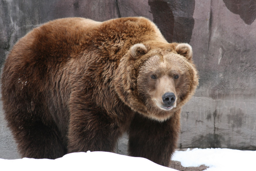

In [8]:
im = Image.open(dest) 
im.to_thumb(256,256)

In [9]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images(f'{o} bear')
        download_images(dest, urls=results)

In [11]:
fns = get_image_files(path)
fns

(#85) [Path('bears/grizzly/ef2affff-dc25-4786-9e42-f475595a932a.jpg'),Path('bears/grizzly/386ee387-bafa-4922-a6d2-bee3333b997c.jpg'),Path('bears/grizzly/0edcf366-4290-4839-857a-5e3e13ec15c4.jpg'),Path('bears/grizzly/1a2ed768-9cc7-416d-9d39-13bb8c4cc790.jpg'),Path('bears/grizzly/9f68c91f-6c99-4efe-aea3-dd343e6f7471.jpg'),Path('bears/grizzly/2f0017f8-9603-42b9-b59f-b2679dd3e009.jpg'),Path('bears/grizzly/6e200d92-9d50-47b2-a06a-9cdc61fc55c1.jpg'),Path('bears/grizzly/a5d92ee3-5674-408f-bea3-bdb86946091f.jpg'),Path('bears/grizzly/2c2c242d-075b-44b4-bfce-096992b708e7.jpg'),Path('bears/grizzly/88984b3a-4d8c-44b8-8914-b0daae43d0b3.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/a2538a56-d842-4c02-bdce-ecf22118cabc.jpg')]

In [13]:
failed.map(Path.unlink)

(#1) [None]

In [14]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [15]:
dls = bears.dataloaders(path)

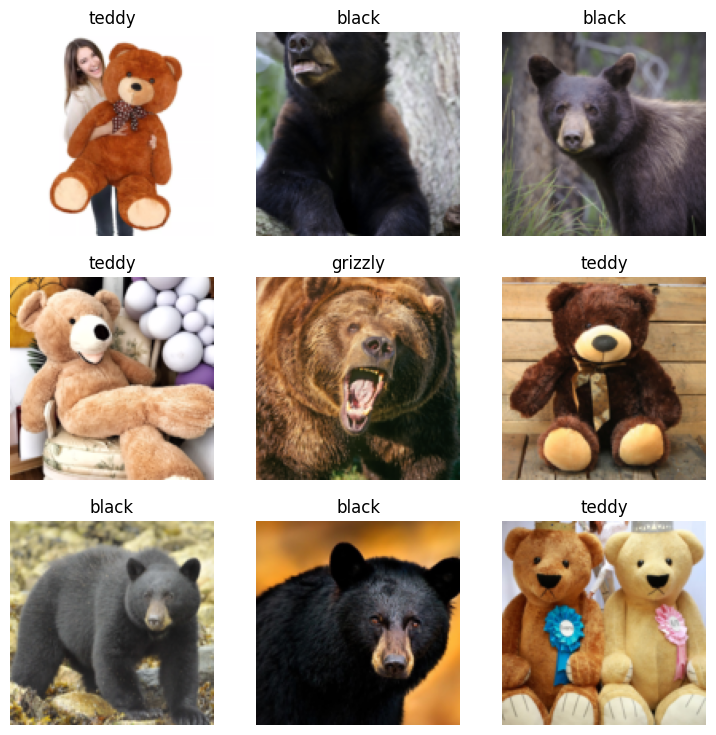

In [16]:
dls.valid.show_batch(max_n=9)

In [17]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                 batch_tfms=aug_transforms())

In [18]:
dls = bears.dataloaders(path)

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/edward/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/edward/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/edward/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


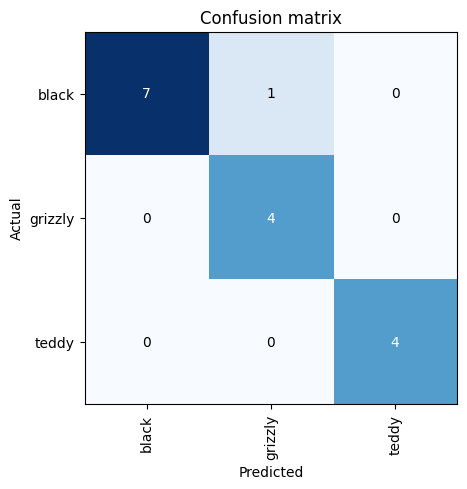

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

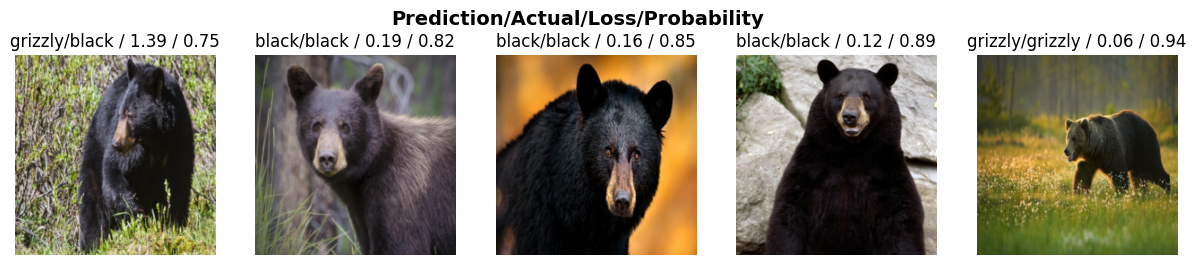

In [21]:
interp.plot_top_losses(5, nrows=1)

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
learn.export()

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learner_inf = load_learner(path/'export.pkl')
learner_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([0.0027, 0.9955, 0.0017]))

In [30]:
learner_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [32]:
img = PILImage.create(btn_upload.data[-1])

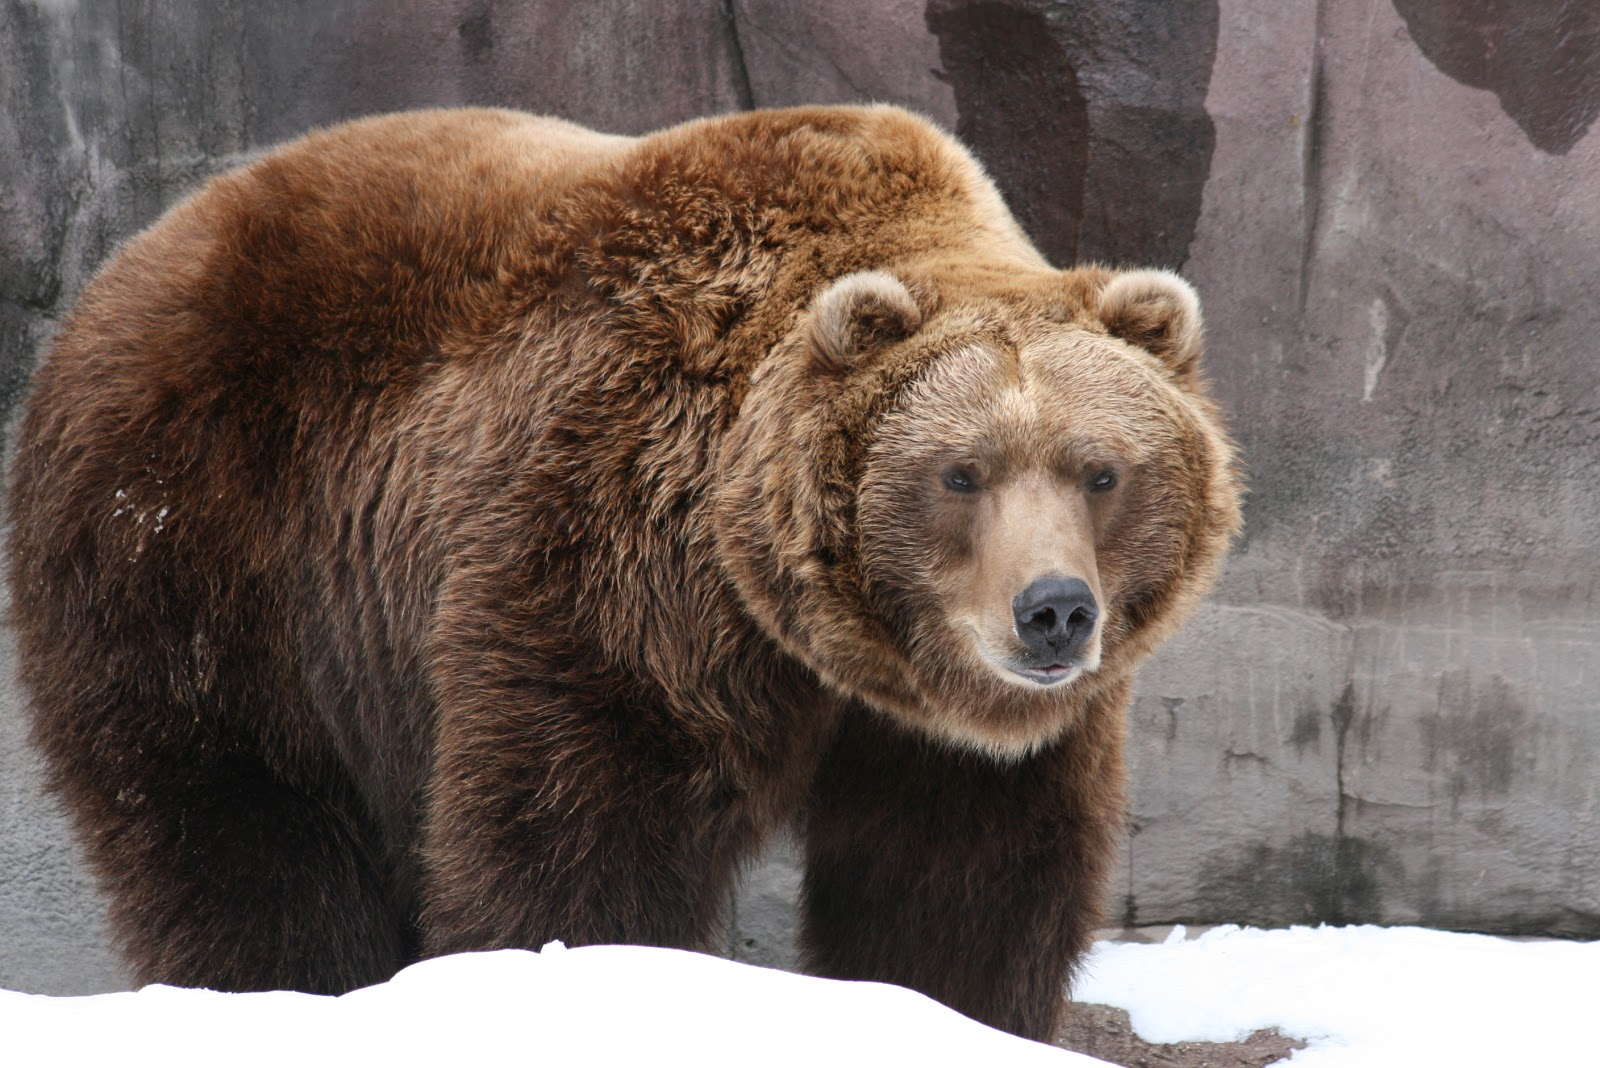

In [33]:
img

In [34]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl    

Output()

In [36]:
pred, pred_idx, probs = learner_inf.predict(img)

In [37]:
lbl_pred = widgets.Label() 
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9955')

In [38]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learner_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [40]:
btn_upload = widgets.FileUpload()

In [41]:
VBox([widgets.Label('Select your bear!'),
     btn_upload, btn_run, out_pl, lbl_pred])

In [44]:
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

Enabling: voila
- Writing config: /opt/homebrew/opt/python@3.9/Frameworks/Python.framework/Versions/3.9/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
